In [50]:
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.models import VGG19_Weights

### Global Variables

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
torch.set_default_device(device)
img_width = 1024
img_height = 1024

### Load Images

In [52]:
def image_loader(style_path, content_path, use_fixed_size=False):
    global img_width, img_height

    style_image = Image.open(style_path)
    content_image = Image.open(content_path)

    width1, height1 = style_image.size
    width2, height2 = content_image.size

    if not use_fixed_size:
        img_width = min(width1, width2)
        img_height = min(height1, height2)

    transform = transforms.Compose([transforms.Resize((img_height, img_width)), transforms.ToTensor()])
    style_image = transform(style_image).unsqueeze(0)
    content_image = transform(content_image).unsqueeze(0)

    return style_image.to(device, torch.float), content_image.to(device, torch.float)

def image_display(tensor, title=None):
    plt.figure()
    transform = transforms.ToPILImage()
    
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = transform(img)
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

### Content Loss

In [53]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None

    def forward(self, input):
        self.loss = mse_loss(input, self.target)
        return input

### Style Loss

In [54]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d) 
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None

    def forward(self, input):
        self.loss = mse_loss(gram_matrix(input), self.target)
        return input

### Normalization

In [55]:
class Normalization(nn.Module):

    def __init__(self):
        super(Normalization, self).__init__()

        cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
        cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

        self.mean = torch.tensor(cnn_normalization_mean).view(-1, 1, 1)
        self.std = torch.tensor(cnn_normalization_std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [56]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_styleLoss_contentLosses(vgg19, target_style_img, target_content_img, content_layers=content_layers_default, style_layers=style_layers_default):
    normalization = Normalization()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in vgg19.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)  # In place ReLU does not work well
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(target_content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(target_style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Remove layers after the last content and style losses layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [57]:
def start_NST(vgg19, optimizer, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1, learning_rate=0.01, momentum=0.9, weight_decay=0.0001):

    NST, style_losses, content_losses = get_model_styleLoss_contentLosses(vgg19, style_img, content_img)

    input_img.requires_grad_(True)
    NST.eval()
    NST.requires_grad_(False)

    assert optimizer in ("sgd", "adam", "lbfgs")

    if optimizer == "sgd":
        optimizer = optim.SGD(NST.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    elif optimizer == "adam":
        optimizer = optim.Adam(NST.parameters(), lr=learning_rate)

    elif optimizer == "lbfgs":
        optimizer = optim.LBFGS([input_img])

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Not calculate the gradients, and the program explicitly uses it here (as with most neural networks) in order to not update the gradients when it is updating the weights as that would affect the back propagation.
            with torch.no_grad():
                # ensure that the pixel values of the generated image (input_img) are within the valid range [0, 1] since when you use the transforms.ToTensor() transformation in torchvision, it automatically converts the pixel values from [0, 255] to [0, 1] by dividing each pixel value by 255.
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            NST(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            print('Step: {} Style Loss : {:4f} Content Loss: {:4f}'.format(run[0], style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Width: 454, Height: 300


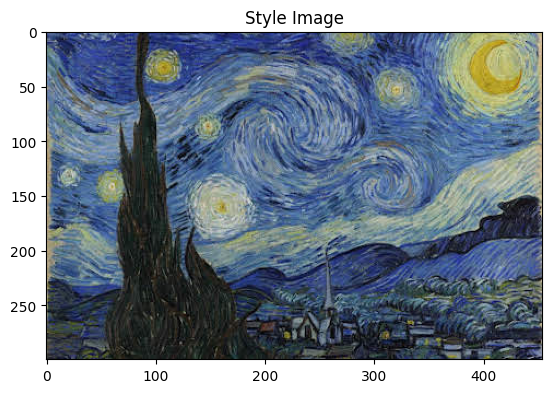

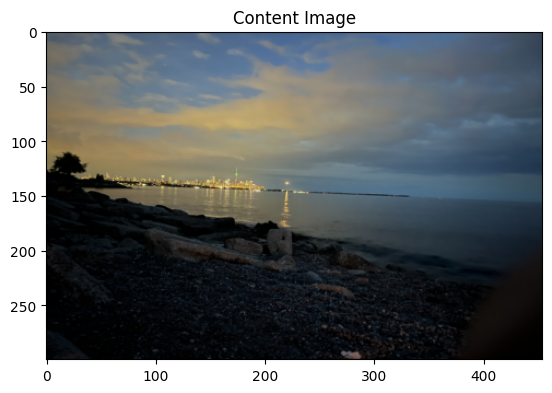

Step: 1 Style Loss : 16316.430664 Content Loss: 0.000000
Step: 2 Style Loss : 16313.612305 Content Loss: 0.000001
Step: 3 Style Loss : 20342270.000000 Content Loss: 389.138733
Step: 4 Style Loss : 7970151.500000 Content Loss: 297.499512
Step: 5 Style Loss : 5841243.500000 Content Loss: 214.001480
Step: 6 Style Loss : 641590.875000 Content Loss: 94.640289
Step: 7 Style Loss : 153669.625000 Content Loss: 64.095886
Step: 8 Style Loss : 83203.640625 Content Loss: 54.450539
Step: 9 Style Loss : 34815.023438 Content Loss: 43.287209
Step: 10 Style Loss : 18211.013672 Content Loss: 36.572659
Step: 11 Style Loss : 11293.908203 Content Loss: 32.030682
Step: 12 Style Loss : 7128.676270 Content Loss: 28.952869
Step: 13 Style Loss : 3926.909424 Content Loss: 29.585312
Step: 14 Style Loss : 2595.968994 Content Loss: 28.957720
Step: 15 Style Loss : 2038.111206 Content Loss: 29.786858
Step: 16 Style Loss : 1711.735718 Content Loss: 29.555317
Step: 17 Style Loss : 1429.416870 Content Loss: 29.859423
St

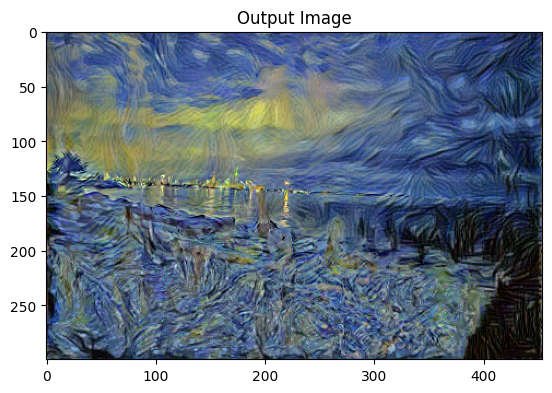

In [58]:
# Load pre-trained VGG19 model
vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

# Load images and check image sizes
style_img, content_img = image_loader(style_path="./fangao.jpeg", content_path="./img3.jpeg")
input_img = content_img.clone()

assert style_img.size() == content_img.size()
print("Width: {}, Height: {}".format(img_width, img_height))

# Display images
plt.ion()
image_display(style_img, title='Style Image')
image_display(content_img, title='Content Image')

# Start training
output = start_NST(vgg19, optimizer="lbfgs", content_img=content_img, style_img=style_img, input_img=input_img, num_steps=300, style_weight=1000000)
image_display(output, title='Output Image')
plt.ioff()
plt.show()